<a href="https://colab.research.google.com/github/wander-design/ai_train_mfti2024/blob/main/85olimpiad_ai_vk_images_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений

Базовый ноутбук для решения задания [Всероссийской олимпиады по искусственному интеллекту](https://ai.edu.gov.ru/) "Классификация изображений".

**Направление**: компьютерное зрение.

Для изменения нужно скопировать ноутбук. Файл -> Сохранить копию на диске...

Не забудьте включть GPU: Среда выполнения -> Сменить среду выполнения -> T4 GPU

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

In [2]:
!wget -O train.zip https://www.dropbox.com/scl/fi/2418ow22jrtt5200db5f0/preprocessed_train.zip?rlkey=wvwdozyl1e1h69kxfvtqk4xri&dl=1

--2024-07-11 16:15:35--  https://www.dropbox.com/scl/fi/2418ow22jrtt5200db5f0/preprocessed_train.zip?rlkey=wvwdozyl1e1h69kxfvtqk4xri
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdca91fc33d796c6d2b33a79cf4.dl.dropboxusercontent.com/cd/0/inline/CWjSx4jdr9woGbFnUUb2Mmgv6qK1BQXQop0seRq1ok1ur7SCD1AlBA7BqD-wY8xONOuyeiBQGVWds-tfZKG52c0UaUphNCbTCoJmT6VcRxbXeTvk4mhyL6fFigsiM5jzzB8/file# [following]
--2024-07-11 16:15:36--  https://ucdca91fc33d796c6d2b33a79cf4.dl.dropboxusercontent.com/cd/0/inline/CWjSx4jdr9woGbFnUUb2Mmgv6qK1BQXQop0seRq1ok1ur7SCD1AlBA7BqD-wY8xONOuyeiBQGVWds-tfZKG52c0UaUphNCbTCoJmT6VcRxbXeTvk4mhyL6fFigsiM5jzzB8/file
Resolving ucdca91fc33d796c6d2b33a79cf4.dl.dropboxusercontent.com (ucdca91fc33d796c6d2b33a79cf4.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6017:15::a27d:20f
Connecting

In [3]:
!unzip train.zip

Archive:  train.zip
   creating: preprocessed_train/ads/
  inflating: preprocessed_train/ads/849433210092.jpg  
  inflating: preprocessed_train/ads/861945621054.jpg  
  inflating: preprocessed_train/ads/865768123444.jpg  
  inflating: preprocessed_train/ads/870095804734.jpg  
  inflating: preprocessed_train/ads/870352278842.jpg  
  inflating: preprocessed_train/ads/873327897052.jpg  
  inflating: preprocessed_train/ads/880375832999.jpg  
  inflating: preprocessed_train/ads/882380261462.jpg  
  inflating: preprocessed_train/ads/882923669493.jpg  
  inflating: preprocessed_train/ads/882923741685.jpg  
  inflating: preprocessed_train/ads/884946095656.jpg  
  inflating: preprocessed_train/ads/886971331682.jpg  
  inflating: preprocessed_train/ads/889536700785.jpg  
  inflating: preprocessed_train/ads/890605388698.jpg  
  inflating: preprocessed_train/ads/891584198605.jpg  
  inflating: preprocessed_train/ads/892040162940.jpg  
  inflating: preprocessed_train/ads/892094330115.jpg  
  inflat

Определяем инструмент предварительной обработки изображений из набора данных

In [4]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

Загружаем набор данных

In [5]:
data = datasets.ImageFolder("preprocessed_train", transform=transform)

**Делим набор данных на данные для обучения и проверки**

In [6]:
# train - набор данных для обучения, 90%
# val - проверочный набор данных, 10%
train, val = random_split(data, [0.99, 0.01])

Количество изображений в наборе данных для обучения

In [7]:
len(train)

4898

Количество изображений в проверочном наборе данных

In [8]:
len(val)

49

Создаем загрузчики данных

In [9]:
# Размер мини-выборки
batch_size = 64

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Названия классов

In [10]:
data.class_to_idx

{'ads': 0,
 'animals': 1,
 'cooking': 2,
 'design': 3,
 'entertainment': 4,
 'mass_media': 5,
 'philosophy': 6,
 'travels': 7}

In [11]:
classes = ['ads', 'animals', 'cooking', 'design', 'entertainment',
           'mass_media', 'philosophy', 'travels']

**Просматриваем примеры изображений**



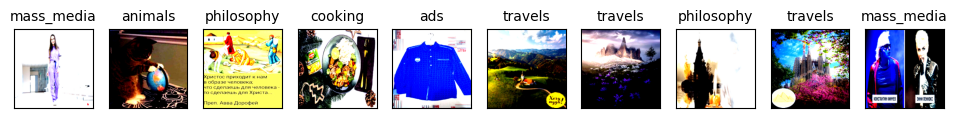

In [12]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [14]:
device

'cuda'

## Предварительно обученная модель

In [15]:
resnet = torchvision.models.resnet101(weights='DEFAULT')
#resnet = torchvision.models.efficientnet_b1(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 158MB/s]


In [16]:
for params in resnet.parameters():
    params.requires_grad = False

In [17]:
#resnet.classifier = nn.Sequential(
resnet.fc = nn.Sequential(
                         nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(1024, 256),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(256, 8))

In [18]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
model = resnet.to(device)
#print(model)

## Обучаем модель

Задаем функцию ошибки - перекрестная энтропия



In [20]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошиби
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на проверочном наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 5 эпох



In [24]:
epochs = 3
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на проверочном наборе данных
    test(valloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 2.065481  [   64/ 4898]
Ошибка: 1.029868  [ 3264/ 4898]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 69.4%, средняя ошибка: 0.794178 

Эпоха 2
-------------------------------
Ошибка: 0.620360  [   64/ 4898]
Ошибка: 0.867594  [ 3264/ 4898]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 71.4%, средняя ошибка: 0.758636 

Эпоха 3
-------------------------------
Ошибка: 0.794912  [   64/ 4898]
Ошибка: 0.671710  [ 3264/ 4898]
Качество на проверочном наборе данных: 
 Доля правильных ответов: 79.6%, средняя ошибка: 0.693140 

Обучение завершено!


In [25]:
test(trainloader, model, loss_fn)

Качество на проверочном наборе данных: 
 Доля правильных ответов: 85.8%, средняя ошибка: 0.437243 



## Распознавание тестового набора данных

### Загрузка тестового набора данных

In [26]:
!wget -O test.zip https://www.dropbox.com/scl/fi/y7tnbaxrh492pqm7wygzy/test.zip?rlkey=yzcgfp8zrv5bimm1mm08acljt&dl=0

--2024-07-11 16:19:43--  https://www.dropbox.com/scl/fi/y7tnbaxrh492pqm7wygzy/test.zip?rlkey=yzcgfp8zrv5bimm1mm08acljt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd905237cde44c4d0792809c6b.dl.dropboxusercontent.com/cd/0/inline/CWgnrst9J08b4BwN-rH00HgWH1TkB4dLHAP6lbWLvFuFT8bMIqK06kveozpV5Jqx-GBWHYXb-WVxHXyLBU1T1_2LehrS21EU9MYd-YGLcQrEcFhr3Qs-HY7BUHjWNhbIstI/file# [following]
--2024-07-11 16:19:44--  https://uccd905237cde44c4d0792809c6b.dl.dropboxusercontent.com/cd/0/inline/CWgnrst9J08b4BwN-rH00HgWH1TkB4dLHAP6lbWLvFuFT8bMIqK06kveozpV5Jqx-GBWHYXb-WVxHXyLBU1T1_2LehrS21EU9MYd-YGLcQrEcFhr3Qs-HY7BUHjWNhbIstI/file
Resolving uccd905237cde44c4d0792809c6b.dl.dropboxusercontent.com (uccd905237cde44c4d0792809c6b.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6031:15::a27d:510f
Connecting to uccd905

In [27]:
!unzip test.zip

Archive:  test.zip
  inflating: test/909340245742       
  inflating: test/909341366963       
  inflating: test/909342962411       
  inflating: test/909343087161       
  inflating: test/909344193109       
  inflating: test/909346841420       
  inflating: test/909353337715       
  inflating: test/909353783353       
  inflating: test/909354605840       
  inflating: test/909355639531       
  inflating: test/909356195897       
  inflating: test/909360236467       
  inflating: test/909362601674       
  inflating: test/909363668178       
  inflating: test/909364341171       
  inflating: test/909364805322       
  inflating: test/909366585478       
  inflating: test/909367412821       
  inflating: test/909369112233       
  inflating: test/909369970054       
  inflating: test/909371570163       
  inflating: test/909371767207       
  inflating: test/909371812491       
  inflating: test/909372480179       
  inflating: test/909373703819       
  inflating: test/909374420102 

### Dataset и DataLoader

Создадим свой класс для загрузки данных из папки

Наследуем от `Dataset`

Особенности написанного класса

* считываются все изображения в папке `img_dir` по индексам, обозначенным в файле `txt_path` (`samples`)
* из файла `txt_path` также берутся метки классов (`target`)

In [28]:
class CustomDataSet(Dataset):
    def __init__(self, txt_path='/content/submission.csv', img_dir='/content/test',
                 transform=None, test=False):
        # df = pd.read_csv(txt_path, sep=';', index_col=0)
        df = pd.read_csv(txt_path, sep=';')
        self.img_names = df['id'].values
        self.df = df
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def get_image_from_folder(self, name):
        # image = Image.open(os.path.join(self.img_dir, str(name)))
        image = Image.open(os.path.join(self.img_dir, str(name))).convert('RGB')
        return image

    def __getitem__(self, idx):
        sample = self.get_image_from_folder(self.img_names[idx])
        if self.transform is not None:
            sample = self.transform(sample)
        target = 0
        return sample, target

Скачиваем шаблон файла для отправки решения

In [29]:
!wget -O submission.csv https://www.dropbox.com/scl/fi/ks1097msvjg0hzcpv7f7i/submission.csv?rlkey=xj4xd2tok1tucuetfysb442rg&dl=1

--2024-07-11 16:20:29--  https://www.dropbox.com/scl/fi/ks1097msvjg0hzcpv7f7i/submission.csv?rlkey=xj4xd2tok1tucuetfysb442rg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc60b337e317ce490c78e3f45c6d.dl.dropboxusercontent.com/cd/0/inline/CWjS4sbAO6RpM9NyZy34s_tiCuGIUZHmIdDk78Qu6i6Iv4vHmvSJlpTQ6hBiyORTxxU100DW0zyu4bTBKsMWJS9LT7NrzOk0CHsfmnQaKsUAhJUizrru8UArfXHmXLLlq8U/file# [following]
--2024-07-11 16:20:30--  https://uc60b337e317ce490c78e3f45c6d.dl.dropboxusercontent.com/cd/0/inline/CWjS4sbAO6RpM9NyZy34s_tiCuGIUZHmIdDk78Qu6i6Iv4vHmvSJlpTQ6hBiyORTxxU100DW0zyu4bTBKsMWJS9LT7NrzOk0CHsfmnQaKsUAhJUizrru8UArfXHmXLLlq8U/file
Resolving uc60b337e317ce490c78e3f45c6d.dl.dropboxusercontent.com (uc60b337e317ce490c78e3f45c6d.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6017:15::a27d:20f
Connecting to uc

In [30]:
!head submission.csv

id;label
909340245742;Развлечения и юмор
909342962411;Развлечения и юмор
909343087161;Развлечения и юмор
909344193109;Развлечения и юмор
909346841420;Развлечения и юмор
909353337715;Развлечения и юмор
909353783353;Развлечения и юмор
909354605840;Развлечения и юмор
909356195897;Развлечения и юмор


In [31]:
submission = pd.read_csv('submission.csv', sep=';', index_col=0)
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Развлечения и юмор
909344193109,Развлечения и юмор
909346841420,Развлечения и юмор
...,...
970656513024,Развлечения и юмор
970691145216,Развлечения и юмор
970699981568,Развлечения и юмор


Создаем DataSet

In [32]:
test_dataset = CustomDataSet(txt_path='/content/submission.csv',
                             img_dir='/content/test',
                             transform=transform)

Создаем загрузчик данных.
Важно - данные в этом случае не надо перемешивать, поскольку при загрузке файла с ответом необходим строгий порядок.

In [33]:
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1,
                          )

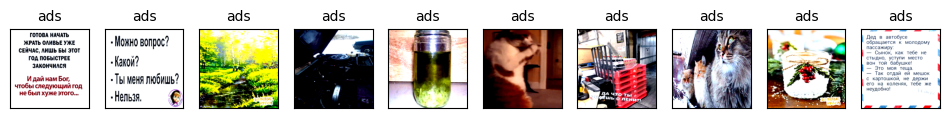

In [34]:
nsamples=10

imgs, labels = next(iter(test_loader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Реализуем предсказание модели на тестовых данных

In [35]:
test_predictions = []

for inputs, _ in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim = 1).data.cpu().numpy())

test_predictions = np.concatenate(test_predictions)


100%|██████████| 81/81 [00:20<00:00,  4.05it/s]


In [36]:
test_predictions[:100]

array([4, 4, 7, 0, 2, 4, 0, 1, 2, 5, 4, 1, 5, 4, 7, 0, 6, 2, 4, 5, 3, 4,
       0, 0, 7, 0, 6, 4, 0, 4, 0, 4, 3, 4, 1, 0, 0, 2, 5, 0, 0, 6, 4, 3,
       3, 4, 7, 4, 0, 0, 4, 7, 4, 2, 0, 3, 0, 7, 7, 4, 0, 0, 2, 2, 7, 4,
       0, 1, 3, 1, 7, 0, 7, 7, 6, 5, 0, 0, 2, 4, 4, 7, 4, 4, 0, 7, 2, 2,
       4, 3, 2, 2, 4, 4, 0, 2, 4, 5, 0, 0])

Откроем файл для загрузки (предсказания заполнены "Развлечения и юмор")

In [37]:
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Развлечения и юмор
909344193109,Развлечения и юмор
909346841420,Развлечения и юмор
...,...
970656513024,Развлечения и юмор
970691145216,Развлечения и юмор
970699981568,Развлечения и юмор


Поместим в файл предсказания модели

In [38]:
submission.label = test_predictions
submission

,label
id,
909340245742,4
909342962411,4
909343087161,7
909344193109,0
909346841420,2
...,...
970656513024,7
970691145216,3
970699981568,7


Заменяем номера классов на их названия

In [39]:
class_names = {
    0: 'Торговля и объявления',
    1: 'Животные',
    2: 'Кулинария',
    3: 'Творчество и дизайн',
    4: 'Развлечения и юмор',
    5: 'СМИ',
    6: 'Философия и религия',
    7: 'Путешествия'
}

In [40]:
submission.replace({'label': class_names}, inplace=True)

In [41]:
submission

,label
id,
909340245742,Развлечения и юмор
909342962411,Развлечения и юмор
909343087161,Путешествия
909344193109,Торговля и объявления
909346841420,Кулинария
...,...
970656513024,Путешествия
970691145216,Творчество и дизайн
970699981568,Путешествия


## Готовим итоговый файл

In [42]:
submission.to_csv('/content/vk_submission.csv',
                  index=True, sep = ';')

In [43]:
!head vk_submission.csv

id;label
909340245742;Развлечения и юмор
909342962411;Развлечения и юмор
909343087161;Путешествия
909344193109;Торговля и объявления
909346841420;Кулинария
909353337715;Развлечения и юмор
909353783353;Торговля и объявления
909354605840;Животные
909356195897;Кулинария


## Идеи по улучшению качества решения

1. Увеличьте количество эпох обучения.
2. Увеличьте количество нейронов в слое классификации, который добавили к ResNet.
3. Поменяете значение dropout_rate в слое Dropout.  
4. Используйте более [глубокую сеть ResNet](https://pytorch.org/hub/pytorch_vision_resnet/).
5. Попробуйте заменить ResNet на более качественную нейронную сеть, например, [EfficientNet](https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/).
6. Используйте [расширение данных](https://colab.research.google.com/drive/1tAi5bWjpUcwCnMWMjhkmMqcjV3D8Vxtz?usp=sharing).